# Module Import Cell

In [2]:
%matplotlib inline
import matplotlib
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
plt.style.use('ggplot') 

## Data Import Cell

In [3]:
#Available population density by state and year meassured in persons per square mile
pop_df = pd.read_csv('data/Historical_Population_Density_States_only_RAND_US_1.csv')
#---------------------------------------------------------------------------------------
#Available firearm background check data
nics_df = pd.read_csv('data/nics-firearm-background-checks.csv')

### Cleaning population data

In [4]:
#Droping NA Values
cleaner_pop_df = pop_df.dropna(axis=1)
#Keeping area and years from 1999 - 2018
cleaner_pop_df = cleaner_pop_df.loc[:, ['Area'] + list(map(str, range(1999, 2019)))]
#Rename 'Area' column to be more descriptive
my_pop_df = cleaner_pop_df.rename(columns={'Area': 'State'})
#test: expect 52 rows(50 states, DC, and US), 21 columns(State name + data from 1999 - 2018)
#my_pop_df.info()
my_pop_df.shape

(52, 21)

### Cleaning NICS data

In [5]:
#Change month to y-m for year by month
nics_df = nics_df.rename(columns={'month': 'y&m'})
#Add year column to group by
nics_df['year'] = list(map(lambda x: x.split('-')[0], nics_df['y&m']))
#Defining columns to combine
handgun_list = ['handgun', 'prepawn_handgun', 'redemption_handgun', 'returned_handgun', 'rentals_handgun', 'private_sale_handgun', 'return_to_seller_handgun']
long_gun_list = ['long_gun', 'prepawn_long_gun', 'redemption_long_gun', 'returned_long_gun', 'rentals_long_gun', 'private_sale_long_gun', 'return_to_seller_long_gun']
#Create combined columns
nics_df['total_handgun'] = nics_df[handgun_list].sum(axis=1)
nics_df['total_long_gun'] = nics_df[long_gun_list].sum(axis=1)
#Group by year then state
year_state_group = nics_df.groupby(('year', 'state')).sum()
#Collect the columns we want and reset index
clean_nics_df = year_state_group[['total_handgun', 'total_long_gun']]
clean_nics_df = clean_nics_df.reset_index()
#Remove any year not between 1999 and 2018 and assign to my_nics_df
clean_nics_df['year'] = pd.to_numeric(clean_nics_df['year'])
my_nics_df = clean_nics_df.loc[(clean_nics_df['year'] < 2019) & (clean_nics_df['year'] > 1998)] 
#Test: Expect 1100 rows (50 states + DC, Guam, Puerto Rico, Mariana Islands, and Virgin Islands X 20 years) and 4 columns
my_nics_df.shape

(1100, 4)

#### Selecting for 2018

In [6]:
#Select the states and population density for 2018, then remove the united states row
my_2018_pop_df = my_pop_df.loc[:, ['State', '2018']]
my_2018_pop_df = my_2018_pop_df[my_2018_pop_df['State'] != 'United States']
#Selecting for year = 2018 and needed rows from NICS data.
nics_2018_df = my_nics_df[my_nics_df['year'] == 2018]
rows_to_drop = ['Guam', 'Mariana Islands', 'Puerto Rico', 'Virgin Islands']
for row in rows_to_drop:
    nics_2018_df = nics_2018_df[nics_2018_df['state'] != row]
#New Variables
  #my_2018_pop_df
  #nics_2018_df

#### Combining and agregating for graphing

In [7]:
#Add population density to NICS data
temp = np.array(my_2018_pop_df['2018'])
nics_2018_df['pop_density'] = temp
#Add column to show ratio of handgun/ rifle applications
nics_2018_df['handgun/long_gun'] = nics_2018_df['total_handgun'] / nics_2018_df['total_long_gun']
#Sorting DF by population density
pop_sorted_nics_2018_df = nics_2018_df.sort_values('pop_density')

# Graphs

## Graph 1

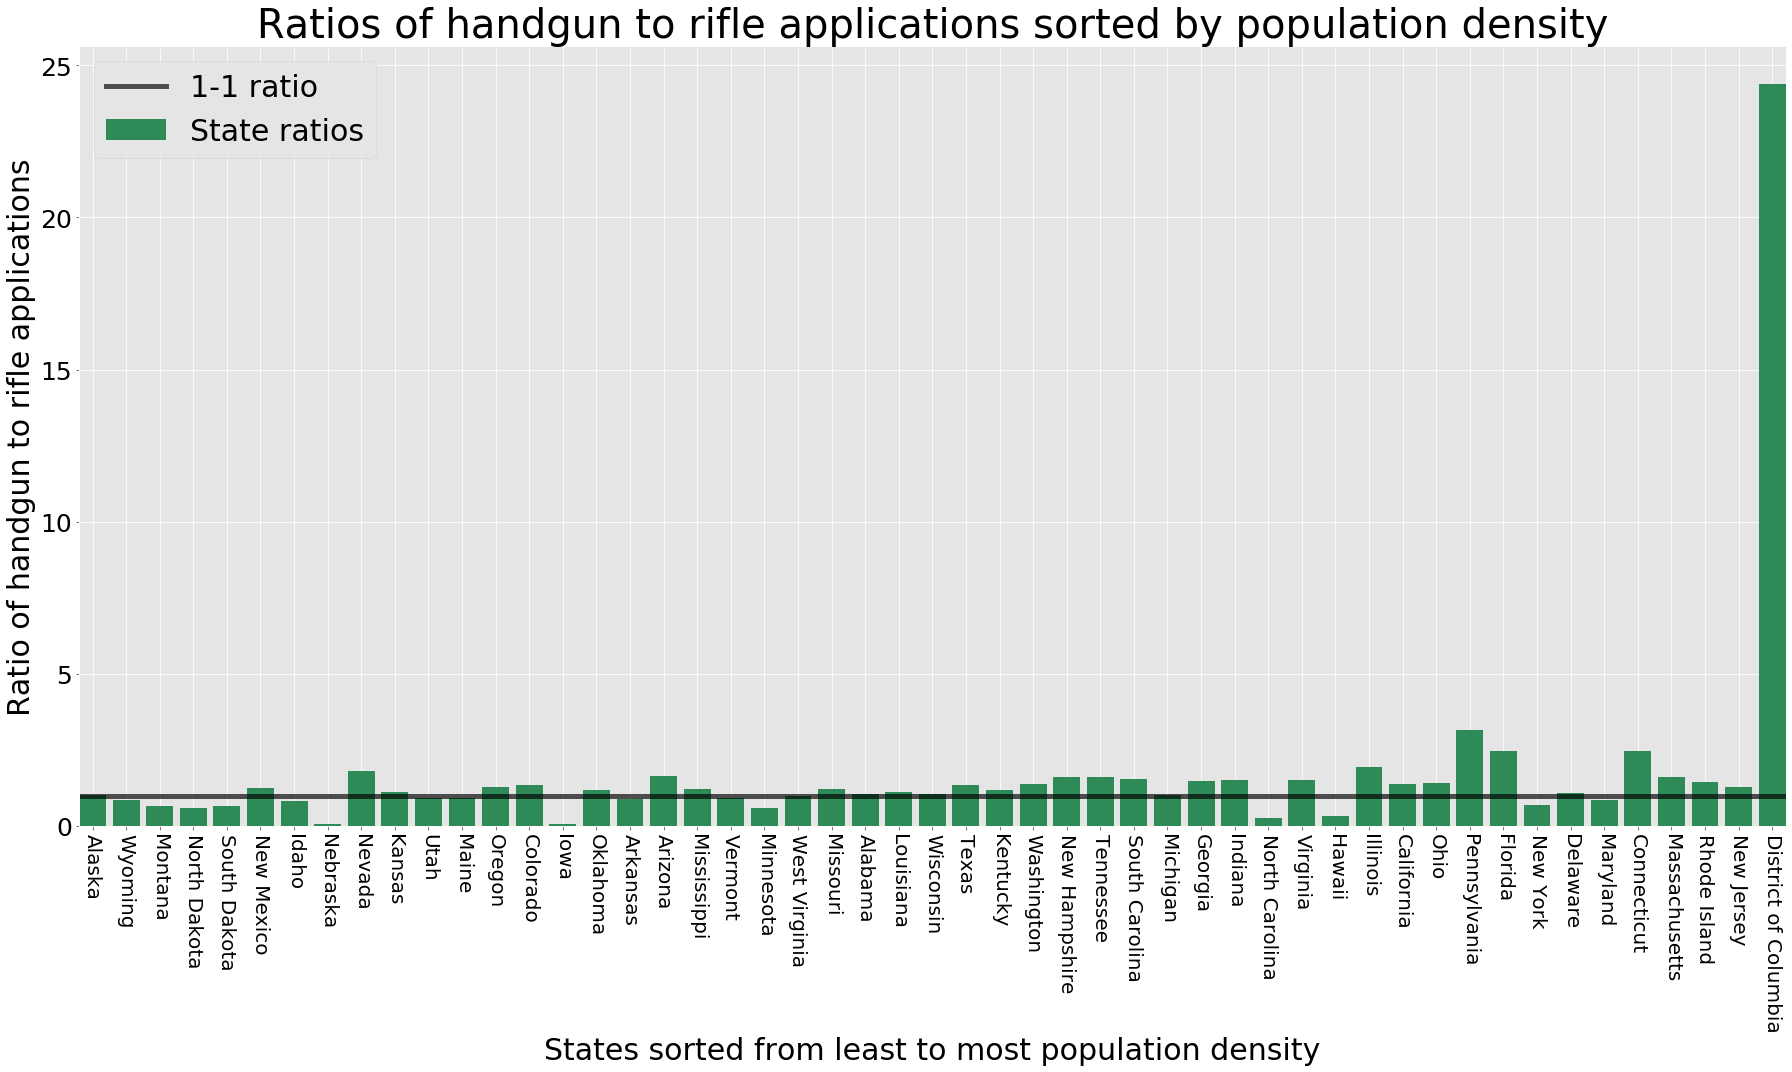

In [92]:
#pop_sorted_nics_2018_df
#Setup
fig, ax = plt.subplots(figsize=(25,15))
labels = np.array(pop_sorted_nics_2018_df['state'])
h_l_r = np.array(pop_sorted_nics_2018_df['handgun/long_gun'])
x = np.arange(len(labels))
#Plot
ax.bar(x, h_l_r, label=('State ratios'), color='seagreen')
ax.axhline(1, color='black', alpha=.666, label='1-1 ratio', lw=5)
ax.set_xticks(x)
#CSS
ax.margins(x=0)
ax.set_ylabel('Ratio of handgun to rifle applications', fontdict={'fontsize': 30, 'fontweight': 5, 'color': 'black'})
ax.set_xlabel('States sorted from least to most population density', fontdict={'fontsize': 30, 'fontweight': 5, 'color': 'black'})
ax.set_xticklabels(labels, rotation=270, fontsize=20, fontweight=4, color='black')
ax.tick_params(axis='y', labelsize=25, labelcolor='black')
ax.set_title('Ratios of handgun to rifle applications sorted by population density', fontdict={'fontsize': 40, 'fontweight': 7})
ax.legend(fontsize=30)
fig.tight_layout()
#V Generates graph image if missing V
#fig.savefig('graphs/bar.png')

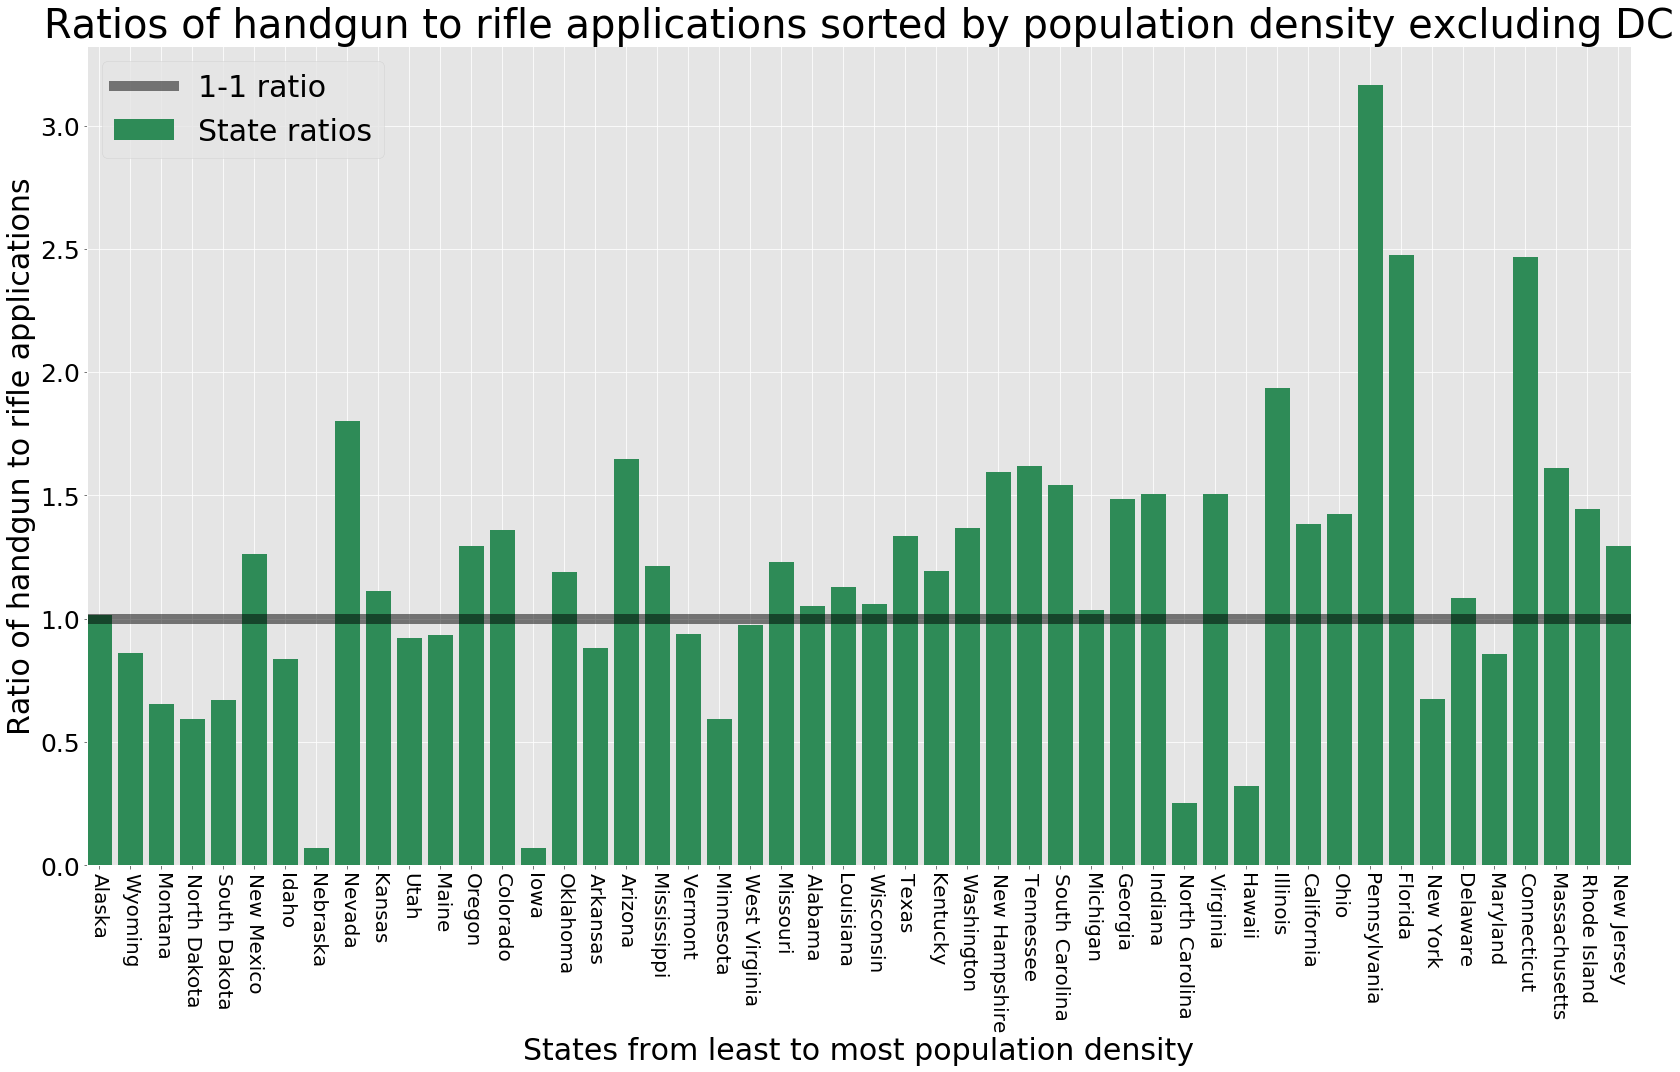

In [89]:
#Exclude DC as obvious outlier
#Setup
noDC_pop_sorted_nics_2018_df = pop_sorted_nics_2018_df[pop_sorted_nics_2018_df['state'] != 'District of Columbia']
fig, ax = plt.subplots(figsize=(25,15))
labels = np.array(noDC_pop_sorted_nics_2018_df['state'])
h_l_r = np.array(noDC_pop_sorted_nics_2018_df['handgun/long_gun'])
x = np.arange(len(labels))
#Plot
ax.bar(x, h_l_r, label=('State ratios'), color='seagreen')
ax.axhline(1, color='black', alpha=.5, label='1-1 ratio', lw=10)
ax.set_xticks(x)
#CSS
ax.margins(x=0)
ax.set_ylabel('Ratio of handgun to rifle applications', fontdict={'fontsize': 30, 'fontweight': 15, 'color': 'black'})
ax.set_xlabel('States from least to most population density', fontdict={'fontsize': 30, 'fontweight': 15, 'color': 'black'})
ax.set_xticklabels(labels, rotation=270, fontsize=20, fontweight=3, color='black')
ax.tick_params(axis='y', labelsize=25, labelcolor='black')
ax.set_title('Ratios of handgun to rifle applications sorted by population density excluding DC', fontdict={'fontsize': 40, 'fontweight': 20})
ax.legend(fontsize=30)
fig.tight_layout()
#V Generates graph image if missing V
#fig.savefig('graphs/bar-noDC.png')

## Graph 2

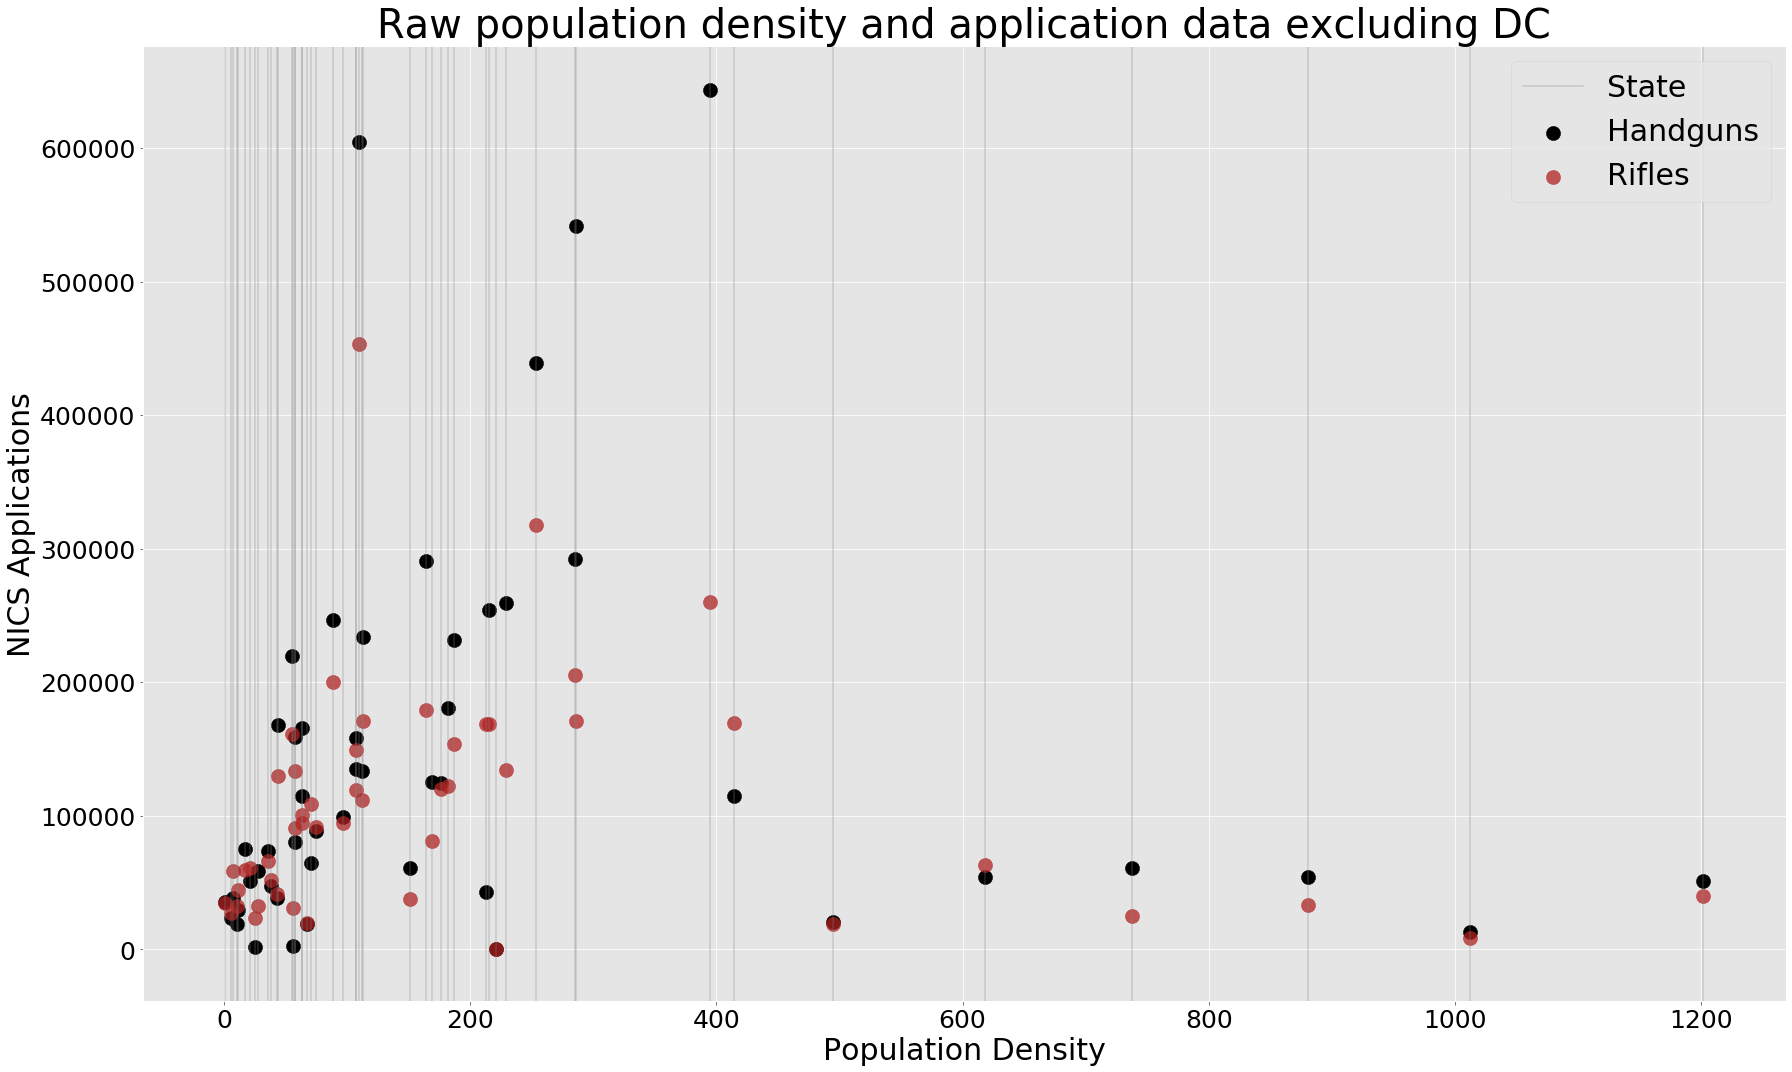

In [75]:
#Remove DC as the obvious outlier 
nics_2018_df_noDC = nics_2018_df[nics_2018_df['state'] != 'District of Columbia']
#Set up plot
fig, ax = plt.subplots(figsize=(25,15))
#Set up variables
x = np.array(nics_2018_df_noDC['pop_density'])
handgun_y = nics_2018_df_noDC['total_handgun']
long_gun_y = nics_2018_df_noDC['total_long_gun']
#Plot
ax.scatter(x, handgun_y, c='black', label='Handguns', alpha=1, s=200)
ax.scatter(x, long_gun_y, c='firebrick', label='Rifles', alpha=.75, s=200)
#Label
ax.set_xlabel('Population Density', fontdict={'fontsize': 30, 'fontweight': 15, 'color': 'black'})
ax.set_ylabel('NICS Applications', fontdict={'fontsize': 30, 'fontweight': 15, 'color': 'black'})
ax.set_title('Raw population density and application data excluding DC', fontdict={'fontsize': 40, 'fontweight': 20})
ax.tick_params(axis='both', labelsize=25, labelcolor='black')
ax.axvline(x[0], color='grey', alpha=.3, label='State')
for i in range(1, len(x)):
    ax.axvline(x[i], color='grey', alpha=.3)
ax.legend(fontsize=30)
fig.tight_layout()
#V Generates graph image if missing V
#fig.savefig('graphs/scatter.png')

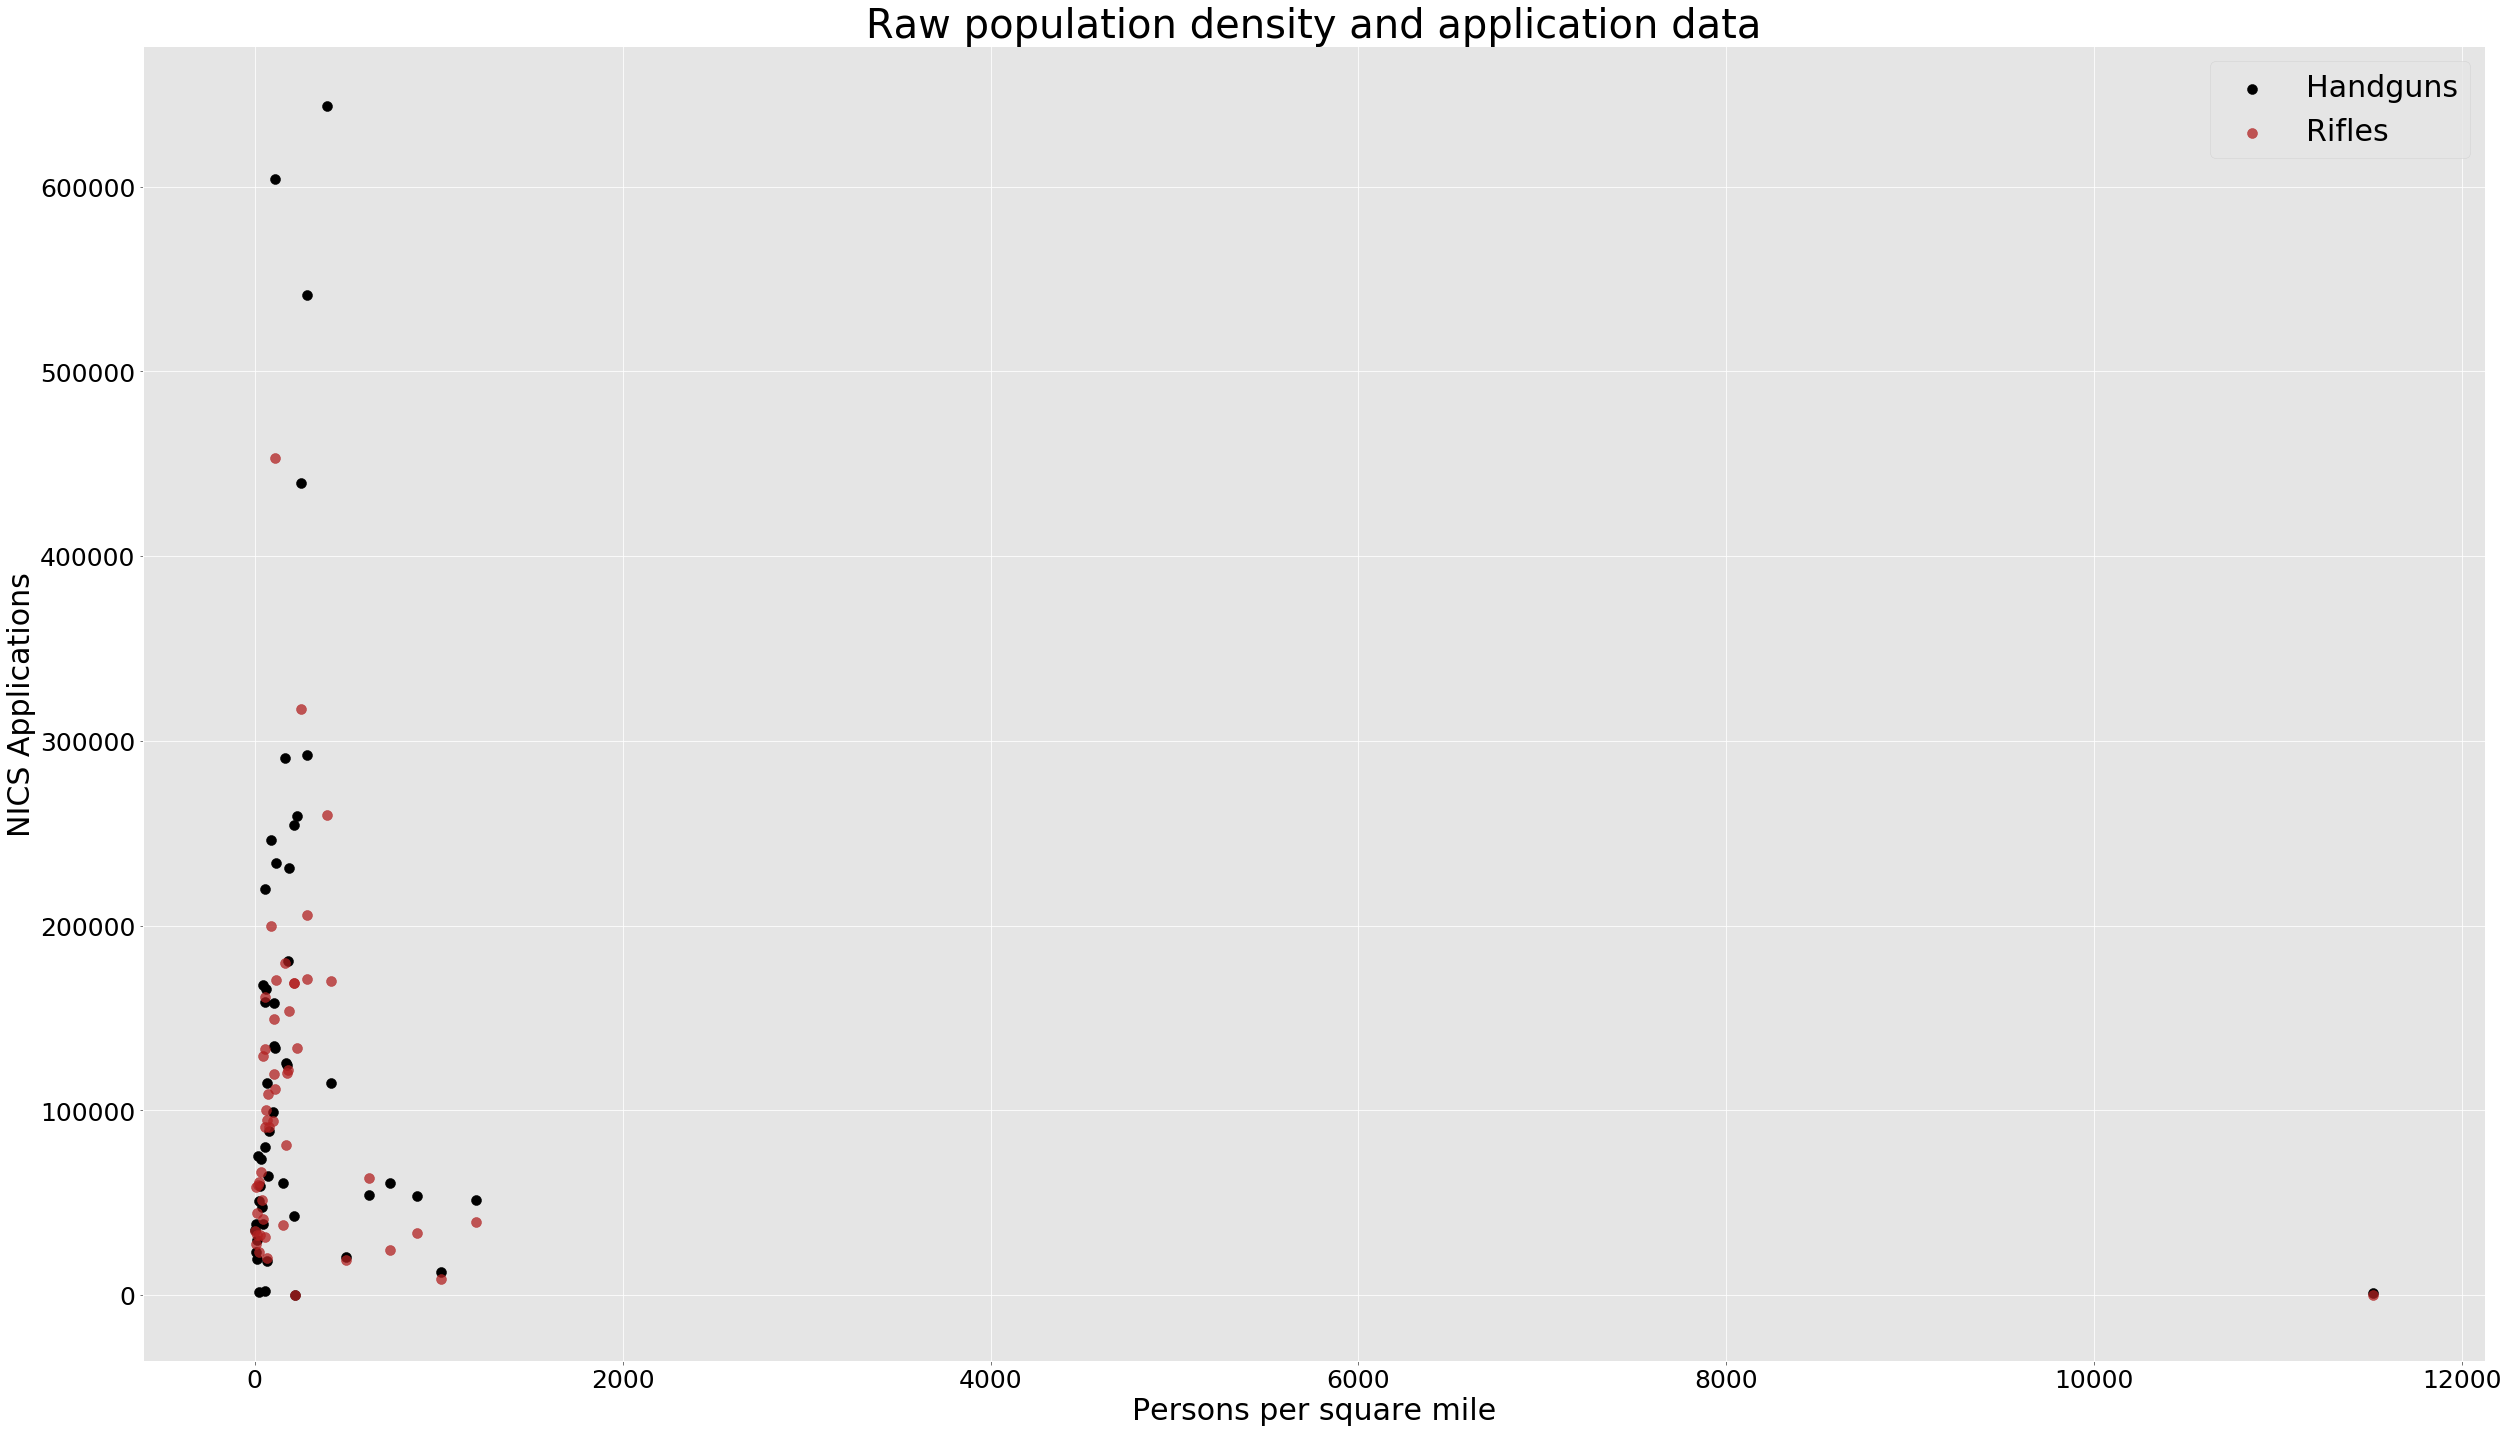

In [74]:
#Show DC as outlier
#Set up plot
fig, ax = plt.subplots(figsize=(35,20))
#Set up variables
x = np.array(nics_2018_df['pop_density'])
handgun_y = nics_2018_df['total_handgun']
long_gun_y = nics_2018_df['total_long_gun']
#Plot
ax.scatter(x, handgun_y, c='black', label='Handguns', alpha=1, s=100)
ax.scatter(x, long_gun_y, c='firebrick', label='Rifles', alpha=.75, s=100)
#Label
ax.set_xlabel('Persons per square mile', fontdict={'fontsize': 30, 'fontweight': 15, 'color': 'black'})
ax.set_ylabel('NICS Applications', fontdict={'fontsize': 30, 'fontweight': 15, 'color': 'black'})
ax.set_title('Raw population density and application data', fontdict={'fontsize': 40, 'fontweight': 20, 'color': 'black'})
ax.tick_params(axis='both', labelsize=25, labelcolor='black')
# ax.axvline(x[0], color='grey', alpha=.3, label='State')
# for i in range(1, len(x)):
#     ax.axvline(x[i], color='grey', alpha=.3)
ax.legend(fontsize = 30)
fig.tight_layout()
#V Generates graph image if missing V
#fig.savefig('graphs/scatter-withDC.png')

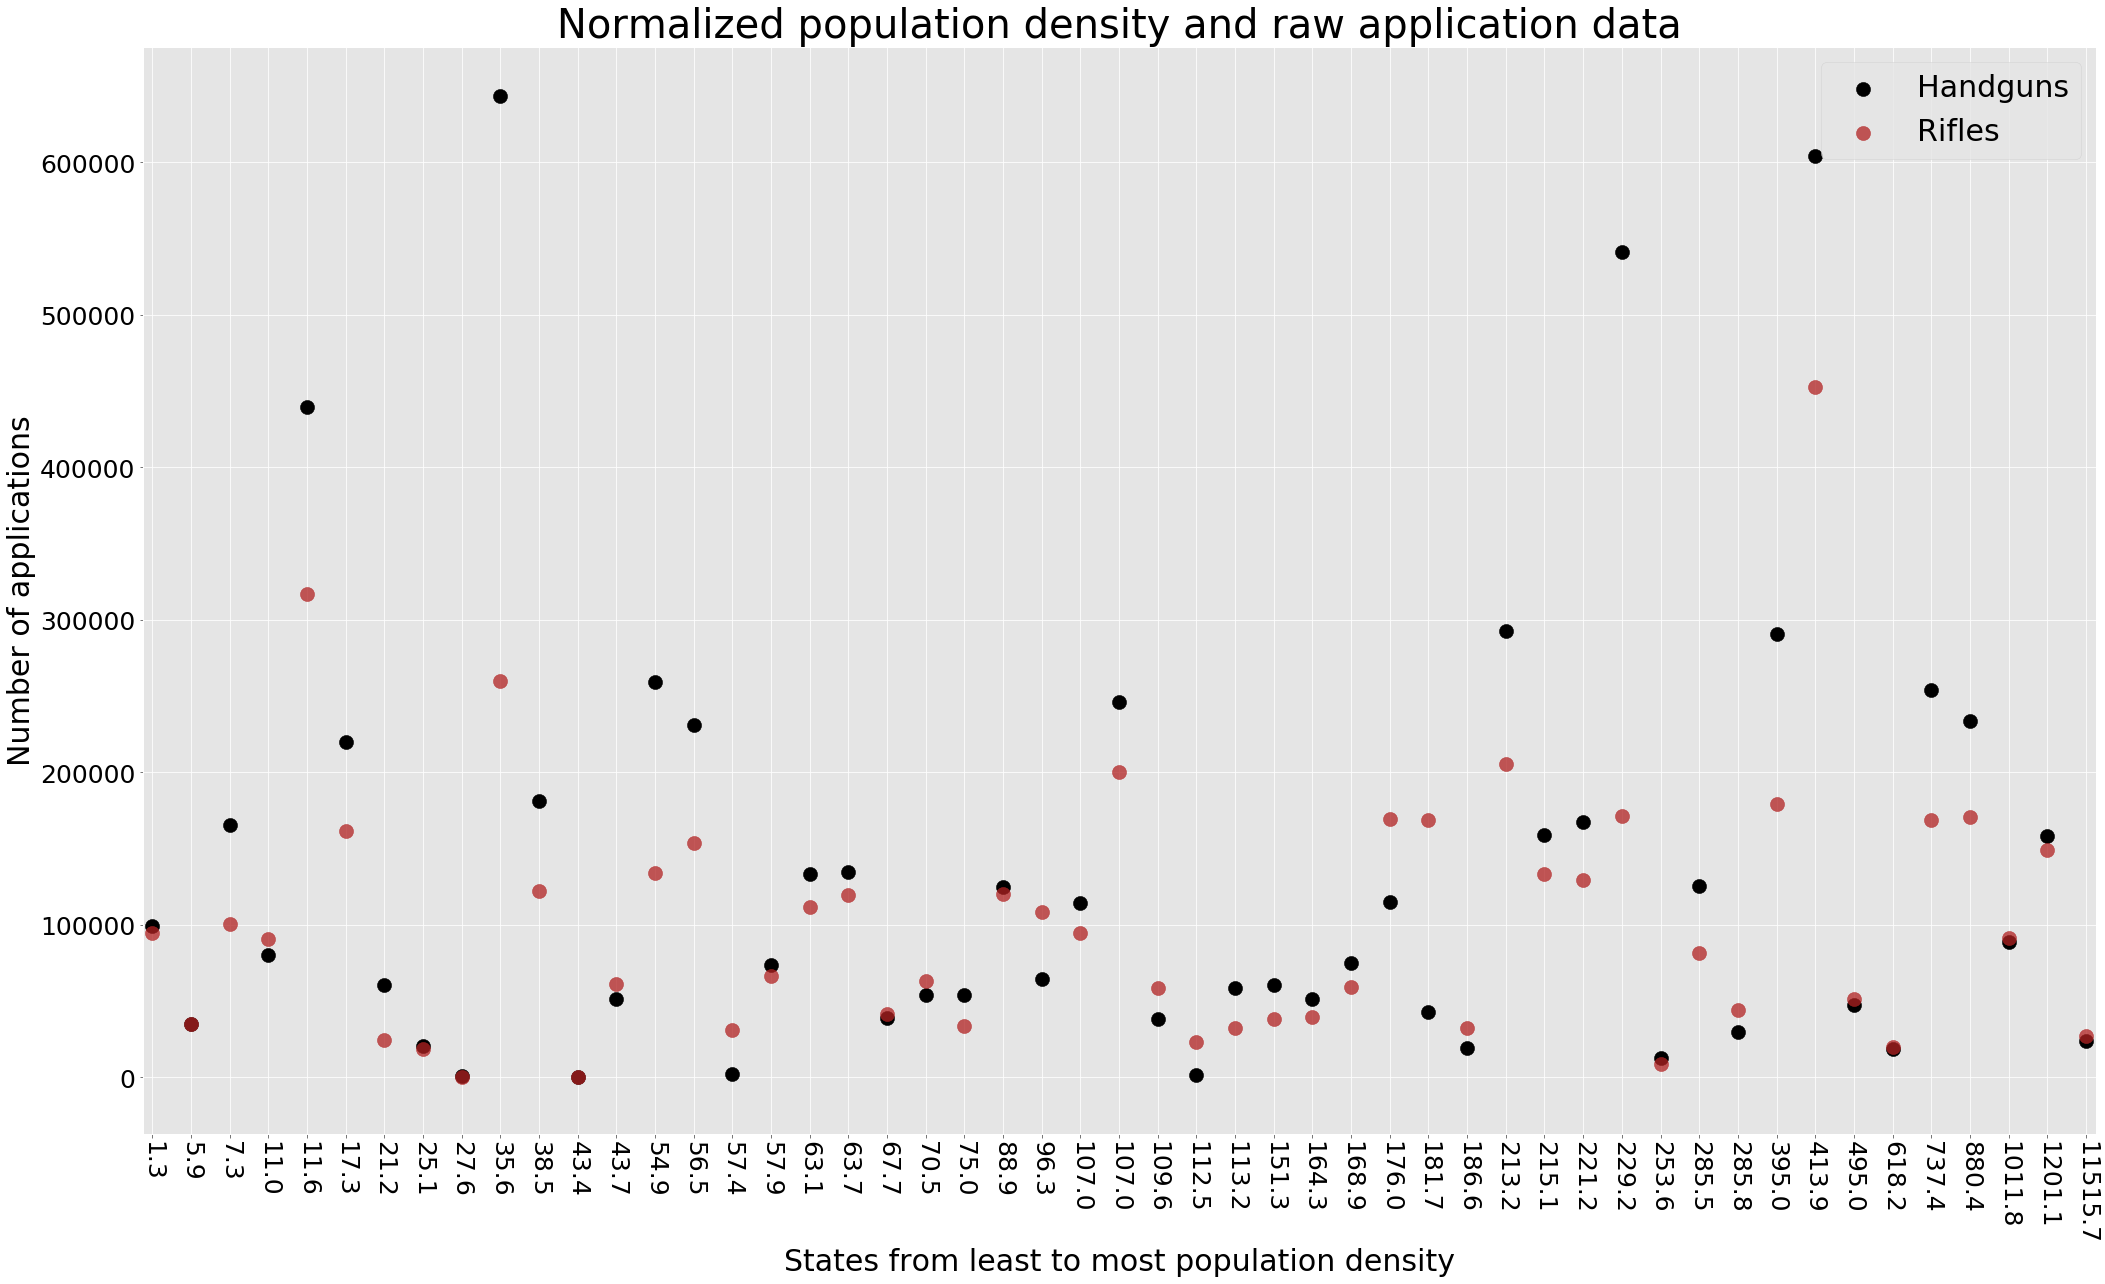

In [73]:
#Setup
fig, ax = plt.subplots(figsize=(35, 20))
xlabels = pop_sorted_nics_2018_df['pop_density']
x = np.arange(len(xlabels))
#Plot 
ax.scatter(x, handgun_y, c='black', label='Handguns', alpha=1, s=200)
ax.scatter(x, long_gun_y, c='firebrick', label='Rifles', alpha=.75, s=200)
ax.set_xticks(x)
#Label
ax.margins(x=.001)
ax.set_xticklabels([round(num, 1) for num in xlabels], rotation=270, fontdict={'fontsize': 25, 'fontweight': 15, 'color': 'black'})
ax.tick_params(axis='y', labelsize=25, labelcolor='black')
ax.set_xlabel('States from least to most population density', fontdict={'fontsize': 30, 'fontweight': 15, 'color': 'black'})
ax.set_ylabel('Number of applications', fontdict={'fontsize': 30, 'fontweight': 15, 'color': 'black'})
ax.set_title('Normalized population density and raw application data', fontdict={'fontsize': 40, 'fontweight': 20})
ax.legend(fontsize=30)
#fig.savefig('graphs/norm-scatter-withDC.png')

0
0
0
0


Text(0, -100000.0, '')

In [13]:
nics_2018_df.describe()

,year,total_handgun,total_long_gun,pop_density,handgun/long_gun
count,51.0,51.000000,51.000000,51.000000,51.000000
mean,2018.0,138054.078431,103376.607843,423.358617,1.654075
std,0.0,149504.351346,85730.347065,1605.799701,3.297579
min,2018.0,10.000000,31.000000,1.289340,0.070503
25%,2018.0,40816.000000,36366.000000,49.284280,0.902616
50%,2018.0,80350.000000,91200.000000,107.044150,1.195177
75%,2018.0,174336.500000,151466.000000,225.189510,1.494312
max,2018.0,643595.000000,452932.000000,11515.655740,24.400000


In [14]:
nics_2018_df_noDC.describe()

,year,total_handgun,total_long_gun,pop_density,handgun/long_gun
count,50.0,50.00000,50.00000,50.000000,50.000000
mean,2018.0,140795.64000,105443.34000,201.512675,1.199157
std,0.0,149721.60192,85307.67805,264.567318,0.571012
min,2018.0,10.00000,31.00000,1.289340,0.070503
25%,2018.0,44137.50000,38391.50000,46.469450,0.892889
50%,2018.0,84545.00000,92793.00000,107.008805,1.193418
75%,2018.0,177639.75000,152579.50000,219.649117,1.474026
max,2018.0,643595.00000,452932.00000,1201.094780,3.162786
